In [1]:

import torch
import random
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split


In [2]:
# Define the categories and the paths to datasets
cates = ['Acne', 'Eczema', 'Rosacea', 'Perioral Dermatitis', 'Psoriasis', 'Seborrheic Dermatitis', 'Tinea Faciei']

data_dir = r""
BATCH_SIZE = 32
EPOCHS = 100
INPUT_SIZE = (227, 227)  

# Set a seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:


# Define a simple transform without normalization for calculating the mean and std
transform_no_normalization = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor()  
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform_no_normalization)

# Print the class-to-label mapping
print("Class to label mapping:", full_dataset.class_to_idx)

# Calculate the split sizes
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.2 * len(full_dataset))    # 20% for validation
test_size = len(full_dataset) - train_size - val_size  # Remaining 10% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Class to label mapping: {'Acne': 0, 'Eczema': 1, 'Perioral Dermatitis': 2, 'Psoriasis': 3, 'Rosacea': 4, 'Seborrheic Dermatitis': 5, 'Tinea Faciei': 6}
Training set size: 2450
Validation set size: 700
Test set size: 350


In [4]:
# Function to calculate mean and std in a single pass
def calculate_mean_std(loader):
    mean = torch.zeros(3)
    var = torch.zeros(3)
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        total_images += batch_samples
        batch_mean = images.mean([0, 2, 3])
        batch_var = images.var([0, 2, 3])

        mean += batch_mean * batch_samples
        var += batch_var * batch_samples

    mean /= total_images
    var /= total_images
    std = torch.sqrt(var)

    return mean, std

# Calculate the mean and std for the training set
mean, std = calculate_mean_std(train_loader)
print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

Calculated mean: tensor([0.6071, 0.4541, 0.4118])
Calculated std: tensor([0.2438, 0.2032, 0.1984])


In [5]:
# Now you can use the calculated mean and std for normalization in your transforms
transform_train = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-10, -10)),
    transforms.RandomRotation(degrees=(10, 10)),
    transforms.RandomRotation(degrees=(-20, -20)),
    transforms.RandomRotation(degrees=(20, 20)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  
])

transform_val_test = transforms.Compose([
    transforms.Resize(INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())  # Use calculated mean and std
])

# Reload the datasets with the new transforms
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=data_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(root=data_dir, transform=transform_val_test)

# Split the datasets again
train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
images, labels = next(iter(train_loader))
print(images.shape)  

torch.Size([32, 3, 227, 227])


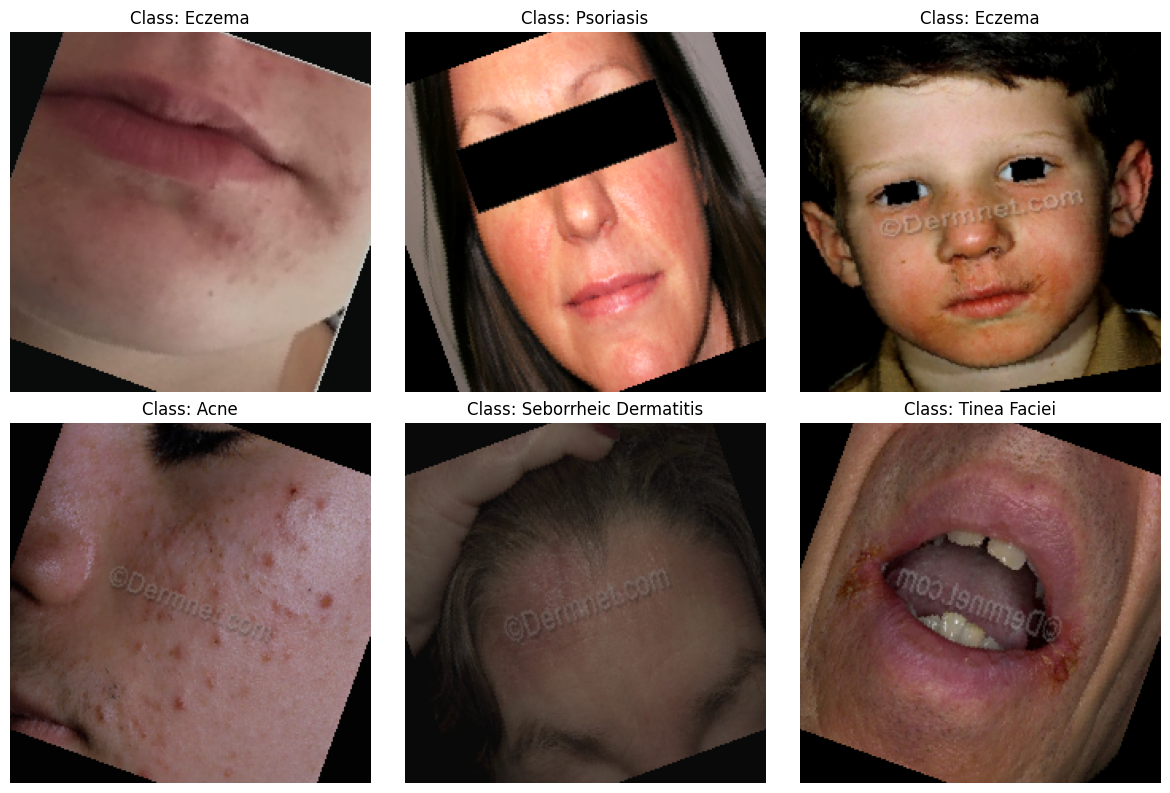

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize the image for visualization
def unnormalize(image, mean, std):
    image = image.numpy().transpose((1, 2, 0))  
    mean = np.array(mean)
    std = np.array(std)
    image = std * image + mean  
    image = np.clip(image, 0, 1)  
    return image

# Visualize a batch of images from the train_loader
def visualize_loader(loader, mean, std, class_names, num_images=6):
    # Get a batch of images
    data_iter = iter(loader)
    images, labels = next(data_iter)  

    # Plot the images
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        image = unnormalize(images[i], mean, std)  
        plt.imshow(image)
        plt.title(f"Class: {class_names[labels[i]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Use this function to visualize a batch of images
visualize_loader(train_loader, mean=mean.tolist(), std=std.tolist(), class_names=cates)

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary


# Load the pretrained AlexNet model
alexnet = models.alexnet(pretrained=False)

# Modify the classifier, adjusting the dropout rates
alexnet.classifier = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(9216, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.6),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, len(cates))
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

# Print the model summary with input size (3 channels for RGB images, and an input size of 227x227)
summary(alexnet, input_size=(3, 227, 227))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr=1e-4, weight_decay=1e-3)


c:\Users\Josh\Desktop\tool-backend\tool\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Josh\Desktop\tool-backend\tool\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [9]:
from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler

# Define the learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

def train_model(model, train_loader, val_loader, epochs, criterion, optimizer, device, scheduler, save_path='best_model.pth'):
    train_losses = []  
    val_losses = []   
    train_accuracies = []  
    val_accuracies = []    

    best_val_accuracy = 0.0  
    best_epoch = 0  

    for epoch in range(epochs):
        # Initialize metrics for training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop 
        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}/{epochs}")
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()  # Zero gradients

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss

                loss.backward()  # Backward pass
                optimizer.step()  # Update weights

                running_loss += loss.item()  # Accumulate loss

                # Calculate training accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                tepoch.set_postfix(loss=running_loss / (tepoch.n + 1), accuracy=100 * correct / total)

        epoch_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total 
        train_losses.append(epoch_train_loss)  
        train_accuracies.append(train_accuracy)  

        # Validation loop with progress bar
        val_loss = 0.0
        correct = 0
        total = 0
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            with tqdm(val_loader, unit="batch", leave=False) as vepoch:
                vepoch.set_description(f"Validation Epoch {epoch+1}/{epochs}")
                for inputs, labels in vepoch:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    # Calculate validation accuracy
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    vepoch.set_postfix(val_loss=val_loss / (vepoch.n + 1), val_accuracy=100 * correct / total)

        epoch_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total 
        val_losses.append(epoch_val_loss) 
        val_accuracies.append(val_accuracy)  

        # Print progress after each epoch
        print(f'\nEpoch [{epoch+1}/{epochs}] - Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        # Step the scheduler based on the validation loss
        scheduler.step(epoch_val_loss)

        # Save the model if validation accuracy improves
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            print(f"New best validation accuracy: {val_accuracy:.2f}% at epoch {best_epoch}. Saving model...\n")
            torch.save(model.state_dict(), save_path)  # Save the best model

    print(f"\nTraining complete. Best validation accuracy: {best_val_accuracy:.2f}% at epoch {best_epoch}")
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model with the scheduler
train_losses, val_losses, train_accuracies, val_accuracies = train_model(alexnet, train_loader, val_loader, EPOCHS, criterion, optimizer, device, scheduler, save_path='alexnet_best_model.pth')

Epoch 1/100: 100%|██████████| 77/77 [00:58<00:00,  1.31batch/s, accuracy=15, loss=1.95]  



Epoch [1/100] - Train Loss: 1.9463, Train Accuracy: 15.02%, Validation Loss: 1.9224, Validation Accuracy: 19.14%
New best validation accuracy: 19.14% at epoch 1. Saving model...



Epoch 2/100: 100%|██████████| 77/77 [00:57<00:00,  1.34batch/s, accuracy=19.6, loss=1.9] 



Epoch [2/100] - Train Loss: 1.8974, Train Accuracy: 19.55%, Validation Loss: 1.9367, Validation Accuracy: 13.29%


Epoch 3/100: 100%|██████████| 77/77 [00:56<00:00,  1.36batch/s, accuracy=21.5, loss=1.87]



Epoch [3/100] - Train Loss: 1.8688, Train Accuracy: 21.47%, Validation Loss: 1.8777, Validation Accuracy: 23.43%
New best validation accuracy: 23.43% at epoch 3. Saving model...



Epoch 4/100: 100%|██████████| 77/77 [00:53<00:00,  1.44batch/s, accuracy=26.2, loss=1.81]



Epoch [4/100] - Train Loss: 1.8062, Train Accuracy: 26.24%, Validation Loss: 1.8037, Validation Accuracy: 27.14%
New best validation accuracy: 27.14% at epoch 4. Saving model...



Epoch 5/100: 100%|██████████| 77/77 [00:55<00:00,  1.38batch/s, accuracy=27.8, loss=1.76]



Epoch [5/100] - Train Loss: 1.7624, Train Accuracy: 27.76%, Validation Loss: 1.7772, Validation Accuracy: 28.29%
New best validation accuracy: 28.29% at epoch 5. Saving model...



Epoch 6/100: 100%|██████████| 77/77 [00:54<00:00,  1.41batch/s, accuracy=29.6, loss=1.73]



Epoch [6/100] - Train Loss: 1.7251, Train Accuracy: 29.59%, Validation Loss: 1.7729, Validation Accuracy: 28.57%
New best validation accuracy: 28.57% at epoch 6. Saving model...



Epoch 7/100: 100%|██████████| 77/77 [00:54<00:00,  1.41batch/s, accuracy=30, loss=1.71]  



Epoch [7/100] - Train Loss: 1.7107, Train Accuracy: 30.00%, Validation Loss: 1.7808, Validation Accuracy: 30.14%
New best validation accuracy: 30.14% at epoch 7. Saving model...



Epoch 8/100: 100%|██████████| 77/77 [00:53<00:00,  1.44batch/s, accuracy=32.3, loss=1.68]



Epoch [8/100] - Train Loss: 1.6786, Train Accuracy: 32.29%, Validation Loss: 1.7025, Validation Accuracy: 31.00%
New best validation accuracy: 31.00% at epoch 8. Saving model...



Epoch 9/100: 100%|██████████| 77/77 [00:58<00:00,  1.32batch/s, accuracy=32.5, loss=1.68]



Epoch [9/100] - Train Loss: 1.6828, Train Accuracy: 32.53%, Validation Loss: 1.7140, Validation Accuracy: 31.71%
New best validation accuracy: 31.71% at epoch 9. Saving model...



Epoch 10/100: 100%|██████████| 77/77 [00:54<00:00,  1.42batch/s, accuracy=33.9, loss=1.65]



Epoch [10/100] - Train Loss: 1.6506, Train Accuracy: 33.92%, Validation Loss: 1.7327, Validation Accuracy: 30.86%


Epoch 11/100: 100%|██████████| 77/77 [00:56<00:00,  1.37batch/s, accuracy=33.1, loss=1.66]



Epoch [11/100] - Train Loss: 1.6625, Train Accuracy: 33.14%, Validation Loss: 1.7113, Validation Accuracy: 33.14%
New best validation accuracy: 33.14% at epoch 11. Saving model...



Epoch 12/100: 100%|██████████| 77/77 [00:54<00:00,  1.42batch/s, accuracy=36, loss=1.62]  



Epoch [12/100] - Train Loss: 1.6163, Train Accuracy: 36.00%, Validation Loss: 1.7040, Validation Accuracy: 34.86%
New best validation accuracy: 34.86% at epoch 12. Saving model...



Epoch 13/100: 100%|██████████| 77/77 [00:54<00:00,  1.40batch/s, accuracy=36.7, loss=1.6] 



Epoch [13/100] - Train Loss: 1.6006, Train Accuracy: 36.73%, Validation Loss: 1.6650, Validation Accuracy: 36.14%
New best validation accuracy: 36.14% at epoch 13. Saving model...



Epoch 14/100: 100%|██████████| 77/77 [00:55<00:00,  1.38batch/s, accuracy=37.8, loss=1.59]



Epoch [14/100] - Train Loss: 1.5942, Train Accuracy: 37.80%, Validation Loss: 1.6828, Validation Accuracy: 35.71%


Epoch 15/100: 100%|██████████| 77/77 [00:56<00:00,  1.37batch/s, accuracy=38.8, loss=1.55]



Epoch [15/100] - Train Loss: 1.5532, Train Accuracy: 38.78%, Validation Loss: 1.6335, Validation Accuracy: 37.14%
New best validation accuracy: 37.14% at epoch 15. Saving model...



Epoch 16/100: 100%|██████████| 77/77 [01:00<00:00,  1.28batch/s, accuracy=41.8, loss=1.53]



Epoch [16/100] - Train Loss: 1.5278, Train Accuracy: 41.80%, Validation Loss: 1.5976, Validation Accuracy: 40.00%
New best validation accuracy: 40.00% at epoch 16. Saving model...



Epoch 17/100: 100%|██████████| 77/77 [00:57<00:00,  1.33batch/s, accuracy=39.6, loss=1.53]



Epoch [17/100] - Train Loss: 1.5329, Train Accuracy: 39.55%, Validation Loss: 1.6393, Validation Accuracy: 38.86%


Epoch 18/100: 100%|██████████| 77/77 [00:57<00:00,  1.33batch/s, accuracy=42.1, loss=1.49]



Epoch [18/100] - Train Loss: 1.4897, Train Accuracy: 42.08%, Validation Loss: 1.6385, Validation Accuracy: 38.00%


Epoch 19/100: 100%|██████████| 77/77 [00:57<00:00,  1.33batch/s, accuracy=43.3, loss=1.48]



Epoch [19/100] - Train Loss: 1.4796, Train Accuracy: 43.35%, Validation Loss: 1.5893, Validation Accuracy: 41.86%
New best validation accuracy: 41.86% at epoch 19. Saving model...



Epoch 20/100: 100%|██████████| 77/77 [00:59<00:00,  1.29batch/s, accuracy=43.5, loss=1.48]



Epoch [20/100] - Train Loss: 1.4819, Train Accuracy: 43.47%, Validation Loss: 1.6264, Validation Accuracy: 38.29%


Epoch 21/100: 100%|██████████| 77/77 [01:06<00:00,  1.16batch/s, accuracy=44.9, loss=1.43]



Epoch [21/100] - Train Loss: 1.4331, Train Accuracy: 44.94%, Validation Loss: 1.5648, Validation Accuracy: 41.43%


Epoch 22/100: 100%|██████████| 77/77 [02:11<00:00,  1.71s/batch, accuracy=47.1, loss=1.4] 



Epoch [22/100] - Train Loss: 1.3974, Train Accuracy: 47.06%, Validation Loss: 1.5534, Validation Accuracy: 42.86%
New best validation accuracy: 42.86% at epoch 22. Saving model...



Epoch 23/100: 100%|██████████| 77/77 [01:34<00:00,  1.23s/batch, accuracy=45.9, loss=1.4] 



Epoch [23/100] - Train Loss: 1.4039, Train Accuracy: 45.92%, Validation Loss: 1.5977, Validation Accuracy: 40.29%


Epoch 24/100: 100%|██████████| 77/77 [01:27<00:00,  1.13s/batch, accuracy=48.2, loss=1.37]



Epoch [24/100] - Train Loss: 1.3740, Train Accuracy: 48.16%, Validation Loss: 1.5563, Validation Accuracy: 42.86%


Epoch 25/100: 100%|██████████| 77/77 [01:37<00:00,  1.27s/batch, accuracy=49.1, loss=1.34]



Epoch [25/100] - Train Loss: 1.3406, Train Accuracy: 49.10%, Validation Loss: 1.5449, Validation Accuracy: 44.29%
New best validation accuracy: 44.29% at epoch 25. Saving model...



Epoch 26/100: 100%|██████████| 77/77 [01:40<00:00,  1.31s/batch, accuracy=50.2, loss=1.33]



Epoch [26/100] - Train Loss: 1.3263, Train Accuracy: 50.16%, Validation Loss: 1.6056, Validation Accuracy: 44.00%


Epoch 27/100: 100%|██████████| 77/77 [01:52<00:00,  1.45s/batch, accuracy=50.8, loss=1.31]



Epoch [27/100] - Train Loss: 1.3061, Train Accuracy: 50.78%, Validation Loss: 1.5753, Validation Accuracy: 45.29%
New best validation accuracy: 45.29% at epoch 27. Saving model...



Epoch 28/100: 100%|██████████| 77/77 [01:50<00:00,  1.44s/batch, accuracy=51.8, loss=1.28]



Epoch [28/100] - Train Loss: 1.2842, Train Accuracy: 51.84%, Validation Loss: 1.5274, Validation Accuracy: 42.29%


Epoch 29/100: 100%|██████████| 77/77 [01:52<00:00,  1.47s/batch, accuracy=53, loss=1.28]  



Epoch [29/100] - Train Loss: 1.2762, Train Accuracy: 52.98%, Validation Loss: 1.4868, Validation Accuracy: 47.43%
New best validation accuracy: 47.43% at epoch 29. Saving model...



Epoch 30/100: 100%|██████████| 77/77 [01:58<00:00,  1.54s/batch, accuracy=53.9, loss=1.25]



Epoch [30/100] - Train Loss: 1.2453, Train Accuracy: 53.88%, Validation Loss: 1.4833, Validation Accuracy: 45.14%


Epoch 31/100: 100%|██████████| 77/77 [02:01<00:00,  1.58s/batch, accuracy=53.4, loss=1.25]



Epoch [31/100] - Train Loss: 1.2516, Train Accuracy: 53.39%, Validation Loss: 1.5431, Validation Accuracy: 42.86%


Epoch 32/100: 100%|██████████| 77/77 [02:12<00:00,  1.71s/batch, accuracy=54.9, loss=1.2] 



Epoch [32/100] - Train Loss: 1.2038, Train Accuracy: 54.94%, Validation Loss: 1.5248, Validation Accuracy: 44.14%


Epoch 33/100: 100%|██████████| 77/77 [02:11<00:00,  1.71s/batch, accuracy=55.8, loss=1.19]



Epoch [33/100] - Train Loss: 1.1906, Train Accuracy: 55.84%, Validation Loss: 1.4726, Validation Accuracy: 48.00%
New best validation accuracy: 48.00% at epoch 33. Saving model...



Epoch 34/100: 100%|██████████| 77/77 [02:15<00:00,  1.76s/batch, accuracy=56.6, loss=1.15]



Epoch [34/100] - Train Loss: 1.1472, Train Accuracy: 56.57%, Validation Loss: 1.5929, Validation Accuracy: 46.00%


Epoch 35/100: 100%|██████████| 77/77 [02:16<00:00,  1.78s/batch, accuracy=55.5, loss=1.19]



Epoch [35/100] - Train Loss: 1.1884, Train Accuracy: 55.51%, Validation Loss: 1.4591, Validation Accuracy: 48.43%
New best validation accuracy: 48.43% at epoch 35. Saving model...



Epoch 36/100: 100%|██████████| 77/77 [02:22<00:00,  1.86s/batch, accuracy=57.9, loss=1.14]



Epoch [36/100] - Train Loss: 1.1445, Train Accuracy: 57.92%, Validation Loss: 1.5142, Validation Accuracy: 45.00%


Epoch 37/100: 100%|██████████| 77/77 [02:42<00:00,  2.11s/batch, accuracy=58.3, loss=1.12]



Epoch [37/100] - Train Loss: 1.1245, Train Accuracy: 58.29%, Validation Loss: 1.5109, Validation Accuracy: 48.14%


Epoch 38/100: 100%|██████████| 77/77 [02:33<00:00,  2.00s/batch, accuracy=59.2, loss=1.09]



Epoch [38/100] - Train Loss: 1.0902, Train Accuracy: 59.18%, Validation Loss: 1.5120, Validation Accuracy: 46.14%


Epoch 39/100: 100%|██████████| 77/77 [02:33<00:00,  2.00s/batch, accuracy=59.4, loss=1.08]



Epoch [39/100] - Train Loss: 1.0819, Train Accuracy: 59.39%, Validation Loss: 1.5450, Validation Accuracy: 46.14%


Epoch 40/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=60, loss=1.08]  



Epoch [40/100] - Train Loss: 1.0796, Train Accuracy: 60.04%, Validation Loss: 1.5399, Validation Accuracy: 48.57%
New best validation accuracy: 48.57% at epoch 40. Saving model...



Epoch 41/100: 100%|██████████| 77/77 [02:48<00:00,  2.19s/batch, accuracy=62.6, loss=1.03]



Epoch [41/100] - Train Loss: 1.0263, Train Accuracy: 62.57%, Validation Loss: 1.5380, Validation Accuracy: 46.57%


Epoch 42/100: 100%|██████████| 77/77 [02:48<00:00,  2.19s/batch, accuracy=62.1, loss=1.03] 



Epoch [42/100] - Train Loss: 1.0275, Train Accuracy: 62.12%, Validation Loss: 1.5272, Validation Accuracy: 48.71%
New best validation accuracy: 48.71% at epoch 42. Saving model...



Epoch 43/100: 100%|██████████| 77/77 [02:44<00:00,  2.14s/batch, accuracy=61.7, loss=1.02] 



Epoch [43/100] - Train Loss: 1.0231, Train Accuracy: 61.67%, Validation Loss: 1.5099, Validation Accuracy: 48.86%
New best validation accuracy: 48.86% at epoch 43. Saving model...



Epoch 44/100: 100%|██████████| 77/77 [02:44<00:00,  2.13s/batch, accuracy=64.1, loss=0.989]



Epoch [44/100] - Train Loss: 0.9887, Train Accuracy: 64.08%, Validation Loss: 1.5120, Validation Accuracy: 49.71%
New best validation accuracy: 49.71% at epoch 44. Saving model...



Epoch 45/100: 100%|██████████| 77/77 [02:48<00:00,  2.19s/batch, accuracy=65, loss=0.97]   



Epoch [45/100] - Train Loss: 0.9697, Train Accuracy: 65.02%, Validation Loss: 1.4907, Validation Accuracy: 50.14%
New best validation accuracy: 50.14% at epoch 45. Saving model...



Epoch 46/100: 100%|██████████| 77/77 [03:00<00:00,  2.35s/batch, accuracy=65.7, loss=0.946]



Epoch [46/100] - Train Loss: 0.9457, Train Accuracy: 65.67%, Validation Loss: 1.5564, Validation Accuracy: 47.86%


Epoch 47/100: 100%|██████████| 77/77 [03:09<00:00,  2.46s/batch, accuracy=69.2, loss=0.844]



Epoch [47/100] - Train Loss: 0.8443, Train Accuracy: 69.22%, Validation Loss: 1.4412, Validation Accuracy: 51.29%
New best validation accuracy: 51.29% at epoch 47. Saving model...



Epoch 48/100: 100%|██████████| 77/77 [03:28<00:00,  2.71s/batch, accuracy=71.3, loss=0.793]



Epoch [48/100] - Train Loss: 0.7927, Train Accuracy: 71.35%, Validation Loss: 1.4492, Validation Accuracy: 51.57%
New best validation accuracy: 51.57% at epoch 48. Saving model...



Epoch 49/100: 100%|██████████| 77/77 [03:20<00:00,  2.60s/batch, accuracy=71.5, loss=0.773]



Epoch [49/100] - Train Loss: 0.7730, Train Accuracy: 71.51%, Validation Loss: 1.5120, Validation Accuracy: 50.43%


Epoch 50/100: 100%|██████████| 77/77 [02:56<00:00,  2.29s/batch, accuracy=73.6, loss=0.755]



Epoch [50/100] - Train Loss: 0.7552, Train Accuracy: 73.59%, Validation Loss: 1.5121, Validation Accuracy: 50.43%


Epoch 51/100: 100%|██████████| 77/77 [03:42<00:00,  2.89s/batch, accuracy=74.1, loss=0.741]



Epoch [51/100] - Train Loss: 0.7412, Train Accuracy: 74.12%, Validation Loss: 1.5340, Validation Accuracy: 51.00%


Epoch 52/100: 100%|██████████| 77/77 [05:32<00:00,  4.31s/batch, accuracy=72, loss=0.751]  



Epoch [52/100] - Train Loss: 0.7507, Train Accuracy: 72.00%, Validation Loss: 1.5264, Validation Accuracy: 50.57%


Epoch 53/100: 100%|██████████| 77/77 [06:29<00:00,  5.06s/batch, accuracy=73.5, loss=0.739]



Epoch [53/100] - Train Loss: 0.7389, Train Accuracy: 73.51%, Validation Loss: 1.5018, Validation Accuracy: 52.86%
New best validation accuracy: 52.86% at epoch 53. Saving model...



Epoch 54/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=74, loss=0.723]  



Epoch [54/100] - Train Loss: 0.7233, Train Accuracy: 74.00%, Validation Loss: 1.5451, Validation Accuracy: 50.71%


Epoch 55/100: 100%|██████████| 77/77 [03:28<00:00,  2.70s/batch, accuracy=73.8, loss=0.72] 



Epoch [55/100] - Train Loss: 0.7197, Train Accuracy: 73.84%, Validation Loss: 1.5515, Validation Accuracy: 52.14%


Epoch 56/100: 100%|██████████| 77/77 [03:02<00:00,  2.38s/batch, accuracy=73.6, loss=0.728]



Epoch [56/100] - Train Loss: 0.7284, Train Accuracy: 73.63%, Validation Loss: 1.5429, Validation Accuracy: 51.00%


Epoch 57/100: 100%|██████████| 77/77 [03:01<00:00,  2.36s/batch, accuracy=75.2, loss=0.707]



Epoch [57/100] - Train Loss: 0.7068, Train Accuracy: 75.22%, Validation Loss: 1.5373, Validation Accuracy: 50.86%


Epoch 58/100: 100%|██████████| 77/77 [03:01<00:00,  2.35s/batch, accuracy=74.5, loss=0.715]



Epoch [58/100] - Train Loss: 0.7155, Train Accuracy: 74.53%, Validation Loss: 1.5235, Validation Accuracy: 51.57%


Epoch 59/100: 100%|██████████| 77/77 [03:07<00:00,  2.44s/batch, accuracy=74.6, loss=0.701]



Epoch [59/100] - Train Loss: 0.7012, Train Accuracy: 74.57%, Validation Loss: 1.5144, Validation Accuracy: 50.86%


Epoch 60/100: 100%|██████████| 77/77 [03:05<00:00,  2.41s/batch, accuracy=76.1, loss=0.68] 



Epoch [60/100] - Train Loss: 0.6805, Train Accuracy: 76.12%, Validation Loss: 1.5615, Validation Accuracy: 51.00%


Epoch 61/100: 100%|██████████| 77/77 [04:10<00:00,  3.25s/batch, accuracy=74.6, loss=0.689]



Epoch [61/100] - Train Loss: 0.6893, Train Accuracy: 74.61%, Validation Loss: 1.5196, Validation Accuracy: 52.29%


Epoch 62/100: 100%|██████████| 77/77 [04:54<00:00,  3.83s/batch, accuracy=74.9, loss=0.702]



Epoch [62/100] - Train Loss: 0.7022, Train Accuracy: 74.86%, Validation Loss: 1.5208, Validation Accuracy: 50.43%


Epoch 63/100: 100%|██████████| 77/77 [03:30<00:00,  2.74s/batch, accuracy=75.5, loss=0.68] 



Epoch [63/100] - Train Loss: 0.6801, Train Accuracy: 75.51%, Validation Loss: 1.4975, Validation Accuracy: 52.86%


Epoch 64/100: 100%|██████████| 77/77 [03:00<00:00,  2.35s/batch, accuracy=76.7, loss=0.667]



Epoch [64/100] - Train Loss: 0.6672, Train Accuracy: 76.65%, Validation Loss: 1.5633, Validation Accuracy: 50.43%


Epoch 65/100: 100%|██████████| 77/77 [03:22<00:00,  2.63s/batch, accuracy=75, loss=0.704]  



Epoch [65/100] - Train Loss: 0.7040, Train Accuracy: 75.02%, Validation Loss: 1.5041, Validation Accuracy: 51.71%


Epoch 66/100: 100%|██████████| 77/77 [03:52<00:00,  3.02s/batch, accuracy=74.7, loss=0.698]



Epoch [66/100] - Train Loss: 0.6981, Train Accuracy: 74.65%, Validation Loss: 1.5065, Validation Accuracy: 54.14%
New best validation accuracy: 54.14% at epoch 66. Saving model...



Epoch 67/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76, loss=0.685]  



Epoch [67/100] - Train Loss: 0.6848, Train Accuracy: 76.00%, Validation Loss: 1.4986, Validation Accuracy: 52.29%


Epoch 68/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76.4, loss=0.669]



Epoch [68/100] - Train Loss: 0.6687, Train Accuracy: 76.37%, Validation Loss: 1.5173, Validation Accuracy: 51.00%


Epoch 69/100: 100%|██████████| 77/77 [03:00<00:00,  2.34s/batch, accuracy=75.5, loss=0.667]



Epoch [69/100] - Train Loss: 0.6667, Train Accuracy: 75.51%, Validation Loss: 1.5495, Validation Accuracy: 52.29%


Epoch 70/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=75.9, loss=0.669]



Epoch [70/100] - Train Loss: 0.6694, Train Accuracy: 75.92%, Validation Loss: 1.5326, Validation Accuracy: 51.14%


Epoch 71/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=75.8, loss=0.676]



Epoch [71/100] - Train Loss: 0.6758, Train Accuracy: 75.84%, Validation Loss: 1.5072, Validation Accuracy: 51.29%


Epoch 72/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=74.2, loss=0.704]



Epoch [72/100] - Train Loss: 0.7040, Train Accuracy: 74.24%, Validation Loss: 1.5530, Validation Accuracy: 51.57%


Epoch 73/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76.7, loss=0.669]



Epoch [73/100] - Train Loss: 0.6694, Train Accuracy: 76.65%, Validation Loss: 1.5455, Validation Accuracy: 51.43%


Epoch 74/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=76.3, loss=0.673]



Epoch [74/100] - Train Loss: 0.6729, Train Accuracy: 76.33%, Validation Loss: 1.5256, Validation Accuracy: 51.57%


Epoch 75/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76, loss=0.675]  



Epoch [75/100] - Train Loss: 0.6748, Train Accuracy: 75.96%, Validation Loss: 1.5253, Validation Accuracy: 51.86%


Epoch 76/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76.2, loss=0.682]



Epoch [76/100] - Train Loss: 0.6821, Train Accuracy: 76.20%, Validation Loss: 1.5495, Validation Accuracy: 52.29%


Epoch 77/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76.3, loss=0.679]



Epoch [77/100] - Train Loss: 0.6785, Train Accuracy: 76.33%, Validation Loss: 1.5476, Validation Accuracy: 51.29%


Epoch 78/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=75.9, loss=0.676]



Epoch [78/100] - Train Loss: 0.6764, Train Accuracy: 75.88%, Validation Loss: 1.5203, Validation Accuracy: 53.29%


Epoch 79/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=75.9, loss=0.675]



Epoch [79/100] - Train Loss: 0.6748, Train Accuracy: 75.88%, Validation Loss: 1.5065, Validation Accuracy: 52.14%


Epoch 80/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=75.5, loss=0.687]



Epoch [80/100] - Train Loss: 0.6870, Train Accuracy: 75.51%, Validation Loss: 1.5550, Validation Accuracy: 51.86%


Epoch 81/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76.3, loss=0.665]



Epoch [81/100] - Train Loss: 0.6648, Train Accuracy: 76.29%, Validation Loss: 1.5792, Validation Accuracy: 49.29%


Epoch 82/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=75.6, loss=0.685]



Epoch [82/100] - Train Loss: 0.6850, Train Accuracy: 75.63%, Validation Loss: 1.4865, Validation Accuracy: 52.71%


Epoch 83/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=75.5, loss=0.673]



Epoch [83/100] - Train Loss: 0.6731, Train Accuracy: 75.51%, Validation Loss: 1.5198, Validation Accuracy: 51.29%


Epoch 84/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=76.5, loss=0.656]



Epoch [84/100] - Train Loss: 0.6555, Train Accuracy: 76.53%, Validation Loss: 1.5494, Validation Accuracy: 53.57%


Epoch 85/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=75.4, loss=0.678]



Epoch [85/100] - Train Loss: 0.6778, Train Accuracy: 75.39%, Validation Loss: 1.5555, Validation Accuracy: 53.29%


Epoch 86/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=75.8, loss=0.671]



Epoch [86/100] - Train Loss: 0.6707, Train Accuracy: 75.76%, Validation Loss: 1.5971, Validation Accuracy: 50.43%


Epoch 87/100: 100%|██████████| 77/77 [02:58<00:00,  2.31s/batch, accuracy=75.5, loss=0.675]



Epoch [87/100] - Train Loss: 0.6746, Train Accuracy: 75.47%, Validation Loss: 1.5028, Validation Accuracy: 52.00%


Epoch 88/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=76.3, loss=0.678]



Epoch [88/100] - Train Loss: 0.6776, Train Accuracy: 76.33%, Validation Loss: 1.4778, Validation Accuracy: 52.14%


Epoch 89/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76.4, loss=0.675]



Epoch [89/100] - Train Loss: 0.6752, Train Accuracy: 76.37%, Validation Loss: 1.5203, Validation Accuracy: 51.57%


Epoch 90/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=76.5, loss=0.673]



Epoch [90/100] - Train Loss: 0.6729, Train Accuracy: 76.53%, Validation Loss: 1.5360, Validation Accuracy: 50.43%


Epoch 91/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=75.4, loss=0.686]



Epoch [91/100] - Train Loss: 0.6865, Train Accuracy: 75.43%, Validation Loss: 1.5089, Validation Accuracy: 52.00%


Epoch 92/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=76.9, loss=0.669]



Epoch [92/100] - Train Loss: 0.6694, Train Accuracy: 76.94%, Validation Loss: 1.5675, Validation Accuracy: 51.14%


Epoch 93/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=75.7, loss=0.682]



Epoch [93/100] - Train Loss: 0.6818, Train Accuracy: 75.67%, Validation Loss: 1.5361, Validation Accuracy: 51.29%


Epoch 94/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=75.8, loss=0.68] 



Epoch [94/100] - Train Loss: 0.6802, Train Accuracy: 75.80%, Validation Loss: 1.5613, Validation Accuracy: 50.43%


Epoch 95/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76.7, loss=0.672]



Epoch [95/100] - Train Loss: 0.6719, Train Accuracy: 76.69%, Validation Loss: 1.5105, Validation Accuracy: 52.71%


Epoch 96/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=76.4, loss=0.669]



Epoch [96/100] - Train Loss: 0.6692, Train Accuracy: 76.45%, Validation Loss: 1.5340, Validation Accuracy: 50.14%


Epoch 97/100: 100%|██████████| 77/77 [02:58<00:00,  2.32s/batch, accuracy=76.1, loss=0.675]



Epoch [97/100] - Train Loss: 0.6746, Train Accuracy: 76.08%, Validation Loss: 1.5406, Validation Accuracy: 51.29%


Epoch 98/100: 100%|██████████| 77/77 [03:00<00:00,  2.34s/batch, accuracy=75.8, loss=0.685]



Epoch [98/100] - Train Loss: 0.6849, Train Accuracy: 75.84%, Validation Loss: 1.5453, Validation Accuracy: 51.86%


Epoch 99/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=76.2, loss=0.695]



Epoch [99/100] - Train Loss: 0.6948, Train Accuracy: 76.24%, Validation Loss: 1.5278, Validation Accuracy: 52.14%


Epoch 100/100: 100%|██████████| 77/77 [02:59<00:00,  2.33s/batch, accuracy=75.6, loss=0.675]
                                                                                                              


Epoch [100/100] - Train Loss: 0.6749, Train Accuracy: 75.63%, Validation Loss: 1.5545, Validation Accuracy: 52.29%

Training complete. Best validation accuracy: 54.14% at epoch 66


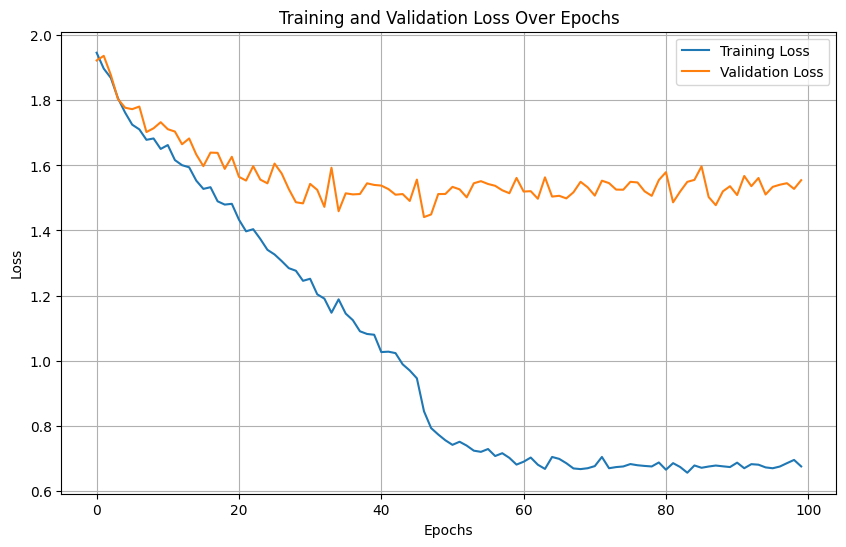

In [10]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_losses(train_losses, val_losses)

In [11]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Helper function to denormalize images for plotting
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()


Classification Report:

                       precision    recall  f1-score   support

                 Acne       0.67      0.65      0.66        49
               Eczema       0.37      0.32      0.34        60
              Rosacea       0.58      0.63      0.61        52
  Perioral Dermatitis       0.38      0.38      0.38        48
            Psoriasis       0.51      0.53      0.52        38
Seborrheic Dermatitis       0.45      0.43      0.44        51
         Tinea Faciei       0.51      0.56      0.53        52

             accuracy                           0.49       350
            macro avg       0.49      0.50      0.50       350
         weighted avg       0.49      0.49      0.49       350



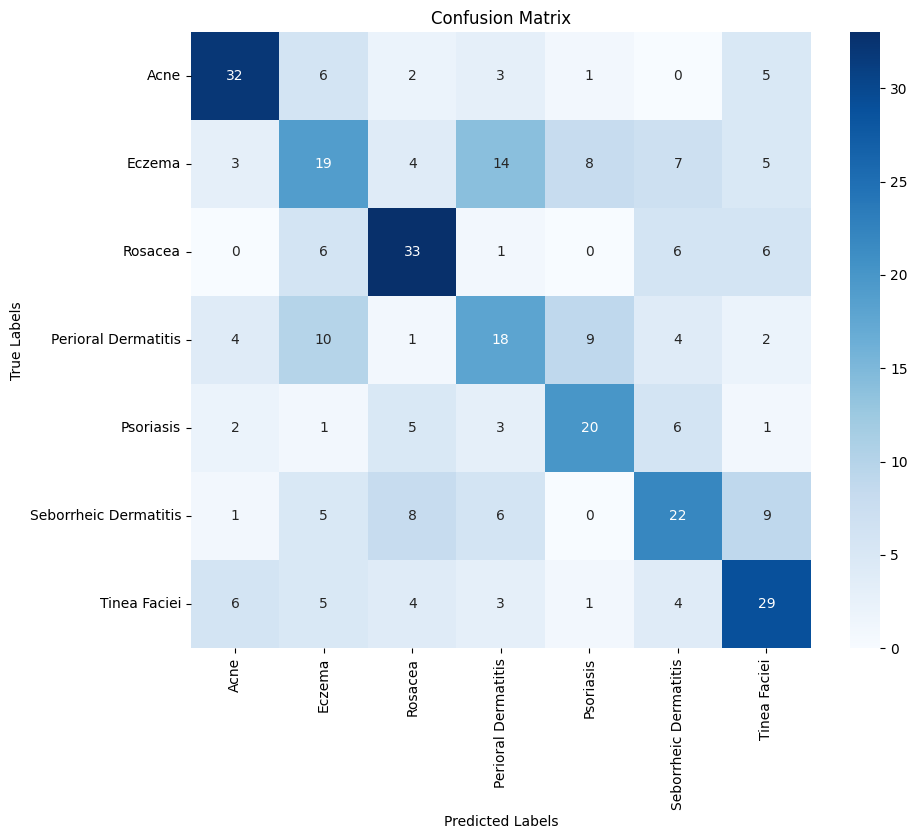

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6162851..0.9447875].


Visualizing some predictions with true labels:



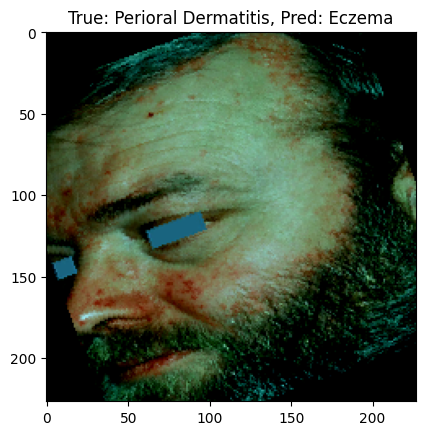

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48761386..1.9233758].


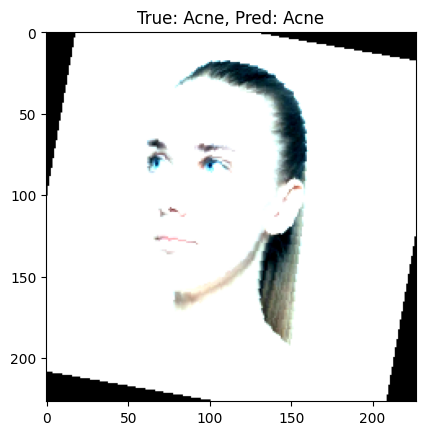

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.6564881].


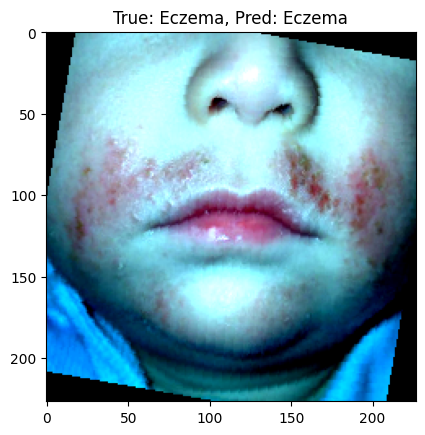

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.9826843].


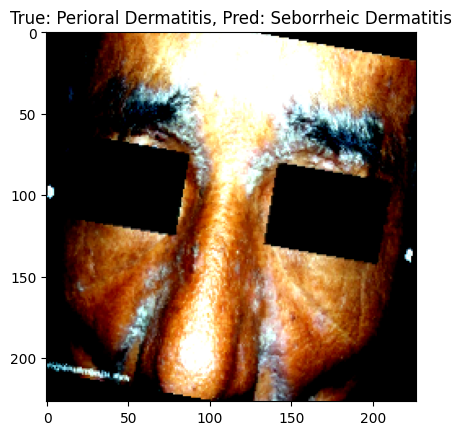

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.0930585].


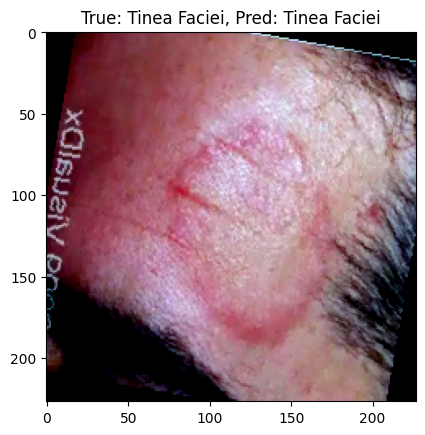

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6967046..1.4093698].


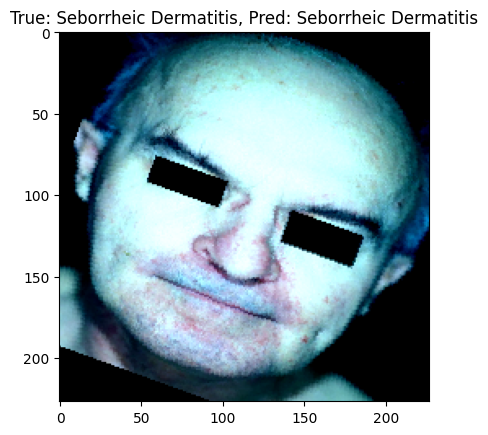

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.9826843].


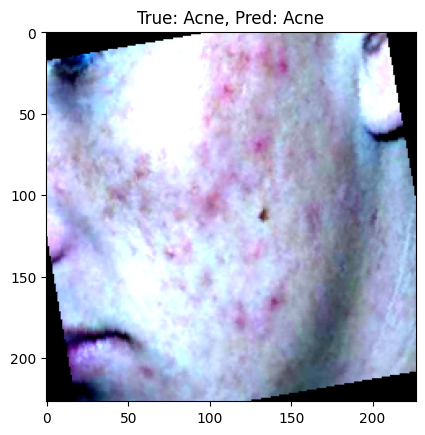

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6162851..1.5576408].


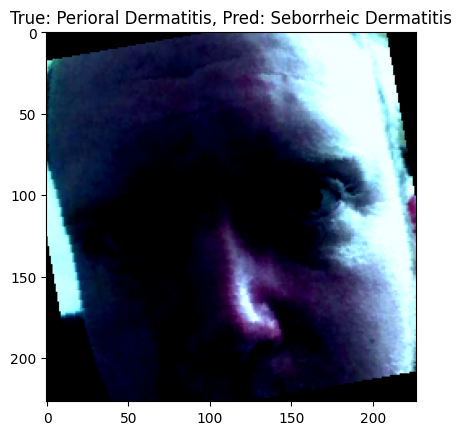

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.9036064].


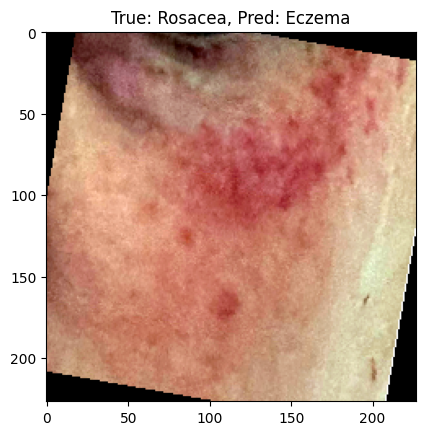

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68866265..1.804759].


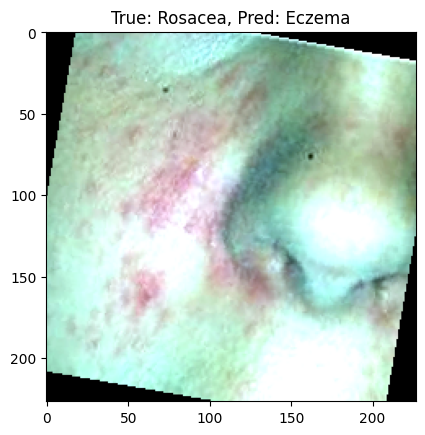

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.7454507].


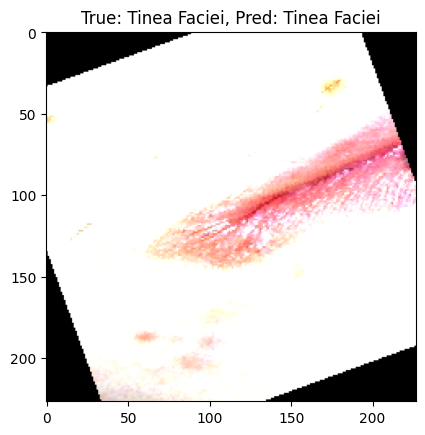

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66453683..1.3401767].


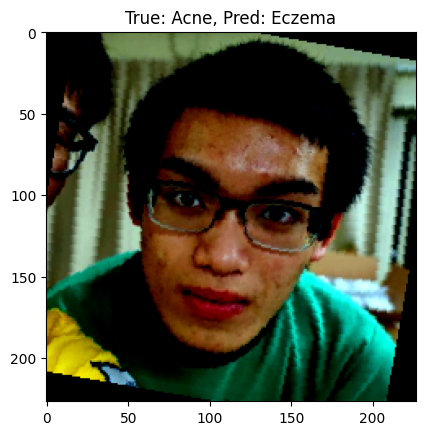

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.9826843].


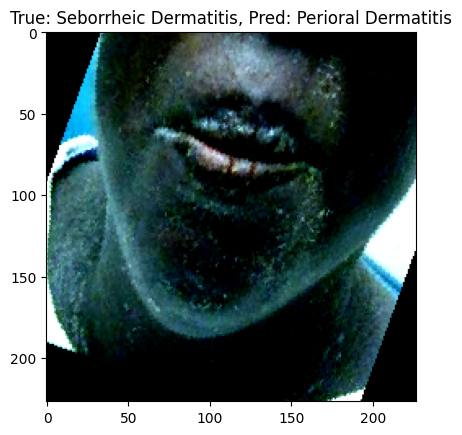

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6806208..1.1227126].


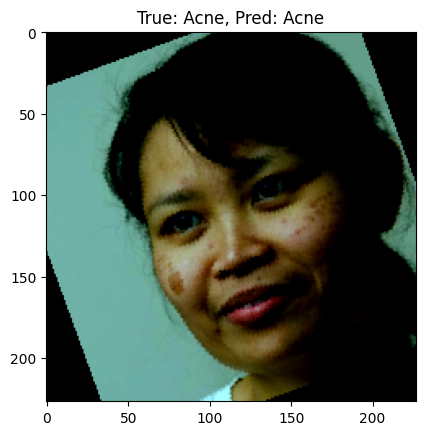

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.63236904..1.4291394].


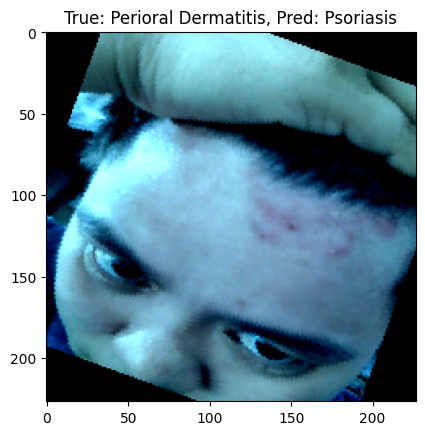

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.8640674].


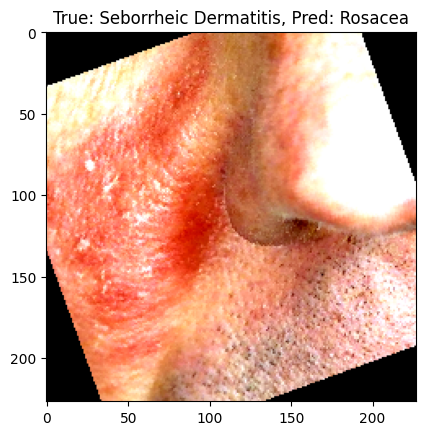

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.72083056..1.1622516].


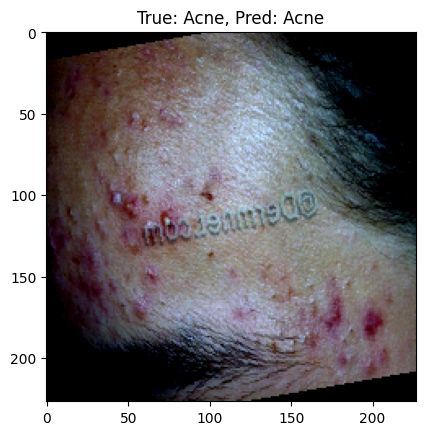

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7288724..1.6211905].


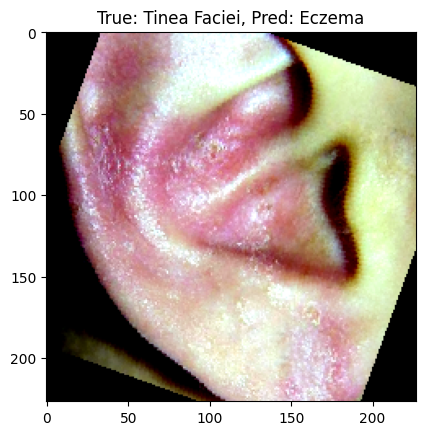

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.6070645].


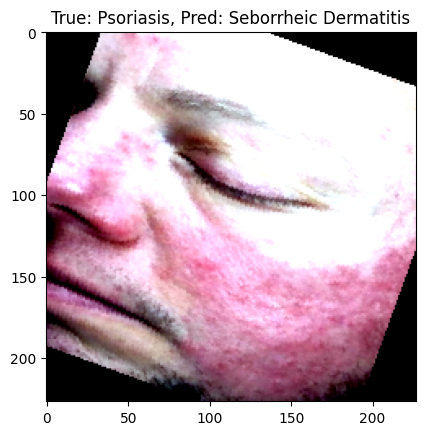

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7127886..1.3105226].


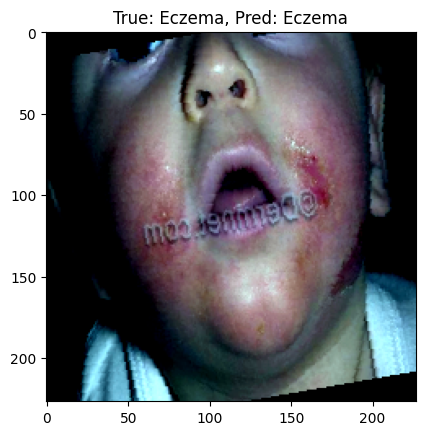

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.65649486..1.4983325].


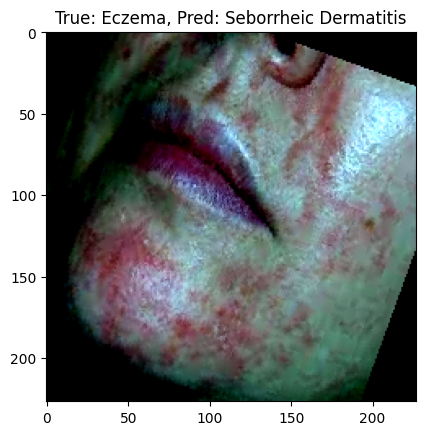

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62432706..1.4192545].


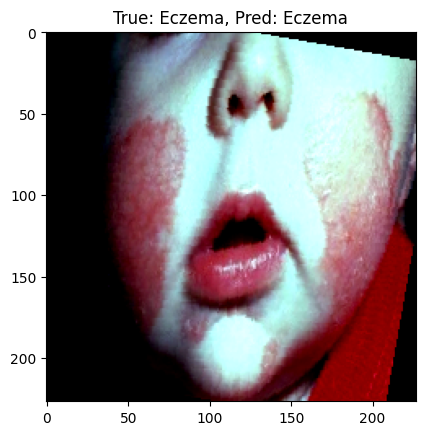

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7127886..1.1523669].


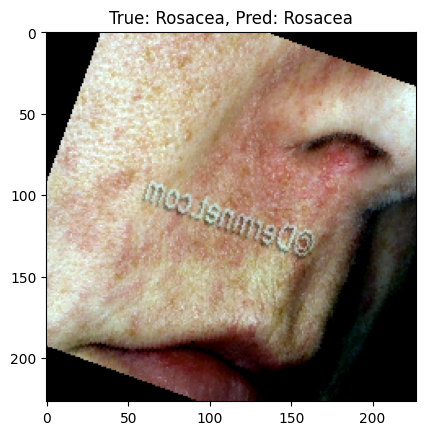

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7449564..1.9826843].


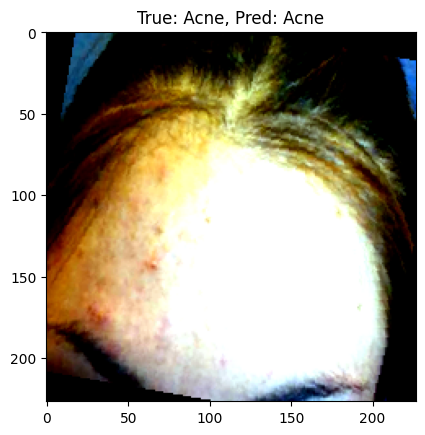

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5921593..1.3401767].


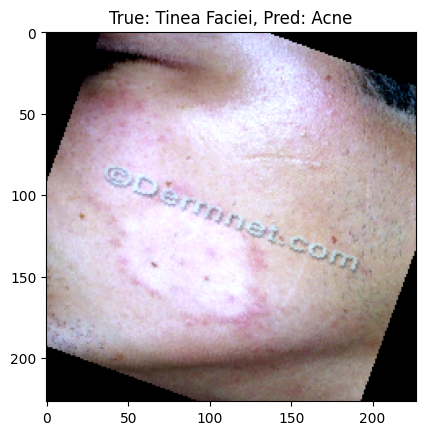

In [12]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    images_to_plot = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Append true labels and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # Store images and corresponding labels for plotting later
            images_to_plot.append((inputs.cpu(), labels.cpu(), predicted.cpu()))

    # Generate classification report
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Plot images with predicted and true labels
    print("Visualizing some predictions with true labels:\n")
    for i, (inputs, labels, preds) in enumerate(images_to_plot[:5]):  # Visualize first 5 batches
        for j in range(min(len(inputs), 5)):  # Visualize 5 images per batch
            img = inputs[j]
            true_label = class_names[labels[j]]
            pred_label = class_names[preds[j]]
            imshow(img, title=f"True: {true_label}, Pred: {pred_label}")

# List of class names (categories)
class_names = cates  # Use the defined categories

# Evaluate the model and generate metrics
evaluate_model(alexnet, test_loader, device, class_names)